In [1]:
#加载库文件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
import random
from sklearn.model_selection import train_test_split
from PIL import Image

import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchinfo import summary

import sys
print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.9.0 (default, Nov 15 2020, 08:30:55) [MSC v.1916 64 bit (AMD64)]
PyTorch version 2.5.1+cu118
Torchvision version 0.20.1+cpu
Numpy version 2.0.2
Pandas version 2.2.3


In [2]:
#检测是否存在cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.device(device)
np.random.seed(42)

In [3]:
hyperparameter_defaults = dict(
    epochs = 100,
    batch_size = 16,
    img_size = 224,
    num_workers = 4,
    model_name = "class_VGG16",
    fc1_out = 1024,
    fc2_out = 64,
    fc3_out = 2
)

import wandb
from datetime import datetime
wandb.login(key="a96035366c44c4ac930354c4d3bda0f9499c339e")
current_time = datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
run_name = "run_" + current_time

config = {
    "project":"Class_VGG16_pytorch",
    "name": run_name,
    "config":hyperparameter_defaults
}
wandb.init(**config)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Leaper\_netrc
wandb: Currently logged in as: huchencao08 (huchencao08-shanghai-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
class customDataset():
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]
        label = self.df.iloc[idx, 1]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [32]:
class DataProcessor:
    def __init__(self, batch_size=32, img_size = 224, workers = 4, train_transform=None, test_transform=None):
        self.batch_size = batch_size
        self.img_size = img_size
        self.workers = workers
        self.classname = []
        self.train_transform = train_transform if train_transform else self._default_transform()
        self.test_transform = test_transform if test_transform else self._default_transform()

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def _default_transform(self):
        return transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def getDataLoader(self, train_dataset, valid_dataset, test_dataset):
        # 为每个子集设置不同的 transform（通过 monkey patch 方法）
        train_dataset.dataset.transform = self.train_transform
        valid_dataset.dataset.transform = self.test_transform
        test_dataset.dataset.transform = self.test_transform
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, 
                                                shuffle=True, num_workers=self.workers)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=self.batch_size, 
                                                shuffle=False, num_workers=self.workers)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=self.batch_size, 
                                                shuffle=False, num_workers=self.workers)
        print("训练集大小：", len(train_loader))
        print("验证集大小：", len(valid_loader))
        print("测试集大小：", len(test_loader))
        return train_loader, valid_loader, test_loader

    #定义数据格式检测函数
    def tr_ts_data(self, tr_dir, ts_dir):
        train_dataset = datasets.ImageFolder(root=tr_dir, transform=None)
        test_dataset = datasets.ImageFolder(root=ts_dir, transform=None)
        test_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
        print("valid分割比例是:", [0.8, 0.2])
        print("all datasets size: ", len(train_dataset), len(valid_dataset), len(test_dataset))
        # 输出类别数
        self.classname = train_dataset.classes
        num_classes = len(train_dataset.classes)
        print(f"Number of categories: {num_classes}")

        train_loader, valid_loader, test_loader = self.getDataLoader(train_dataset, valid_dataset, test_dataset)
        return train_loader, valid_loader, test_loader
        # 使用 DataLoader



    def full_data(self, full_dir):
        full_dataset = datasets.ImageFolder(root=full_dir, transform=None)
        print("总数据集是：", len(full_dataset))
        print("分割比例是:", [0.8, 0.1, 0.1])
        #手动划分train/test数据集
        train_size = int(0.8 * len(full_dataset))
        valid_size = int(0.1 * len(full_dataset))
        test_size = len(full_dataset) - train_size - valid_size
        train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, valid_size, test_size])
        print("all datasets size: ", len(train_dataset), len(valid_dataset), len(test_dataset))
        # 输出类别数
        self.classname = full_dataset.classes
        num_classes = len(full_dataset.classes)
        print(f"Number of categories: {num_classes}")

        train_loader, valid_loader, test_loader = self.getDataLoader(train_dataset, valid_dataset, test_dataset)
        return train_loader, valid_loader, test_loader


    def tr_val_ts_data(self, tr_dir, val_dir, ts_dir):
        train_dataset = datasets.ImageFolder(root=tr_dir, transform=None)
        valid_dataset = datasets.ImageFolder(root=val_dir, transform=None)
        test_dataset = datasets.ImageFolder(root=ts_dir, transform=None)
        print("all datasets size: ", len(train_dataset), len(valid_dataset), len(test_dataset))

        # 输出类别数
        self.classname = train_dataset.classes
        num_classes = len(train_dataset.classes)
        print(f"Number of categories: {num_classes}")
        train_loader, valid_loader, test_loader = self.getDataLoader(train_dataset, valid_dataset, test_dataset)
        return train_loader, valid_loader, test_loader
    
        

In [33]:
train_transform=transforms.Compose([
        transforms.Resize(hyperparameter_defaults["img_size"]),             # resize shortest side to 224 pixels
        #transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        #transforms.CenterCrop(112),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])
test_transform=transforms.Compose([
        transforms.Resize(hyperparameter_defaults["img_size"]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [34]:
#分类图像的路径
data_path = r"D:\code_study\ML_CODE\dataSets\Classification\Pistachio_Image_Dataset\Pistachio_Image_Dataset"
data_path = data_path.replace("\\", "/")
# 创建 DataProcessor 实例
data_processor = DataProcessor(
    img_size=hyperparameter_defaults["img_size"],
    batch_size=hyperparameter_defaults["batch_size"],
    train_transform=train_transform,
    test_transform=test_transform
)

train_dataloader, valid_dataloader, test_dataloader = data_processor.full_data(data_path)

总数据集是： 2148
分割比例是: [0.8, 0.1, 0.1]
all datasets size:  1718 214 216
Number of categories: 2
训练集大小： 108
验证集大小： 14
测试集大小： 14


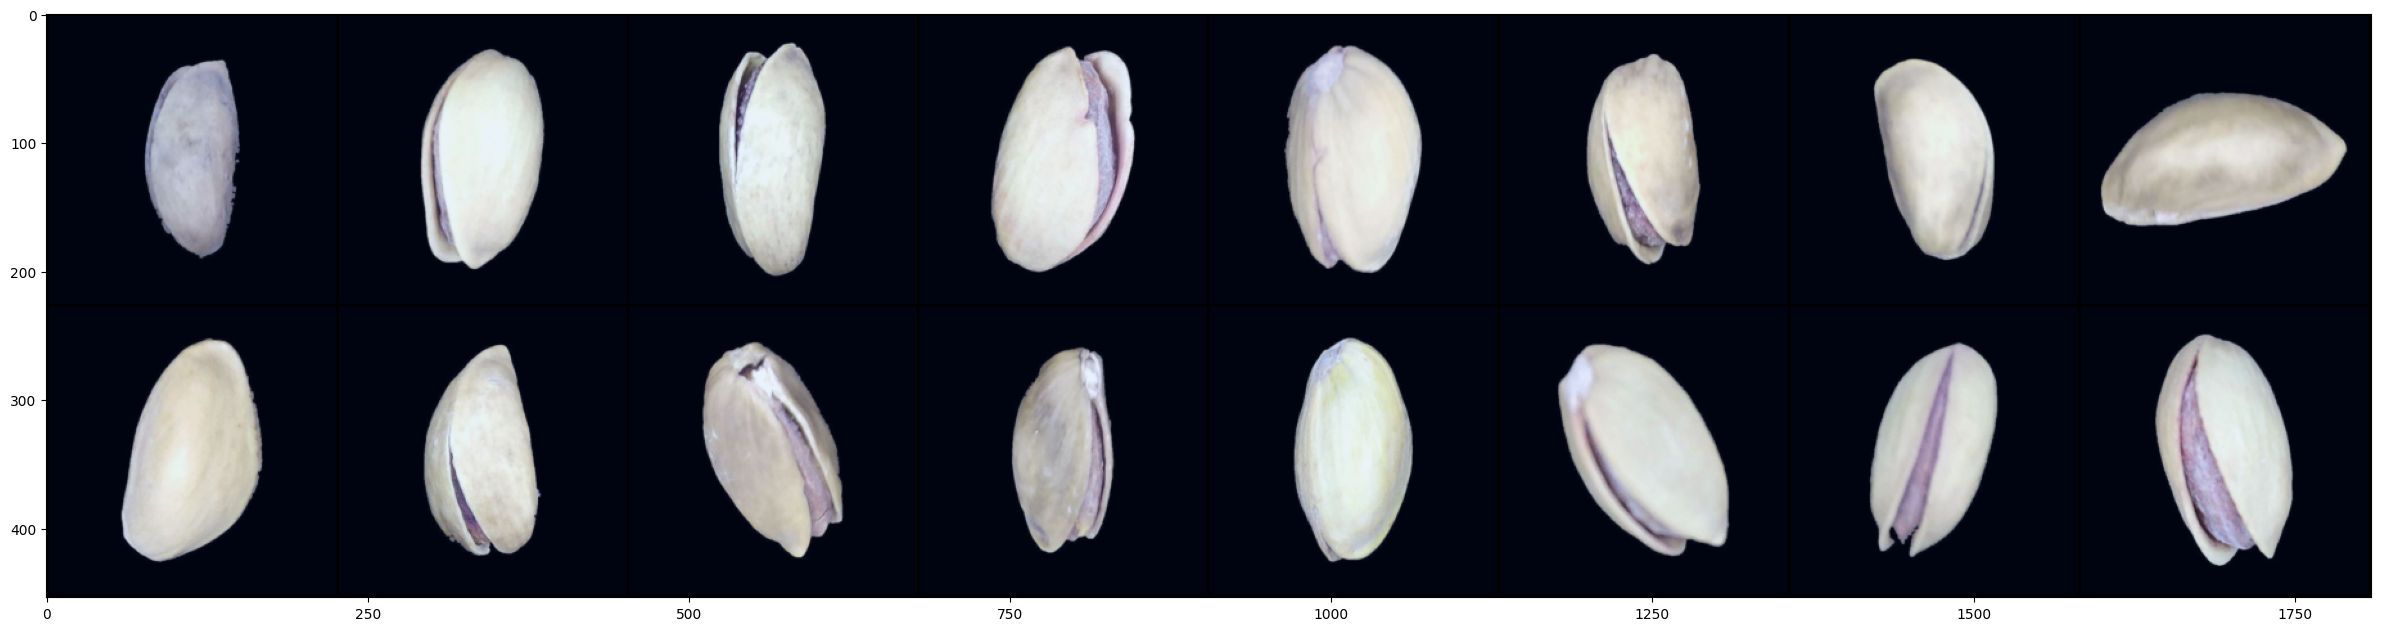

In [35]:
# visualize train data
def visualize(dataloader):
    images , labels = next(iter(dataloader))
    grid = make_grid(images, nrow=8, normalize=True)
    plt.figure(figsize=(30, 30))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.show()
visualize(train_dataloader)

In [38]:
#创建模型
def model_adjustment(p_model):
    for param in p_model.parameters():
        param.requires_grad=False
    return p_model

In [40]:
def model_assets(base_model):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)
    lrp_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    return criterion, optimizer, lrp_scheduler

In [44]:
def model_archive():
    model = torchvision.models.vgg16(pretrained=True)
    model = model_adjustment(model)
    in_features = model.classifier[0].in_features
    print(in_features)
    model.classifier = nn.Sequential(
        nn.Linear(in_features, out_features=hyperparameter_defaults["fc1_out"]),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(hyperparameter_defaults["fc1_out"], out_features=hyperparameter_defaults["fc2_out"]),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(hyperparameter_defaults["fc2_out"], out_features=hyperparameter_defaults["fc3_out"])
    )
    model.to(device)
    criterion, optimizer, lrp_scheduler= model_assets(model) 
    return model, criterion, optimizer, lrp_scheduler

In [45]:
model_vgg, criterion_vgg, optimizer_vgg, lrp_scheduler_vgg = model_archive()

25088


In [52]:
def batch_gd(model, criterion, optimizer, train_loader, valid_loader, epochs, lrp_scheduler):
    train_losses = np.zeros(epochs)
    valid_losses = np.zeros(epochs) 

    for it in range(epochs):
        t0 = datetime.now()
        model.train()
        train_loss = []
        train_total = 0
        train_correct = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            #zero the gradients
            optimizer.zero_grad()
            #forward pass
            outputs = model(inputs)
            _, train_pred = torch.max(outputs, 1)
            loss = criterion(outputs, targets)
            #backward pass
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_total += targets.size(0)
            train_correct += (train_pred == targets).sum().item()

        else:
            model.eval()
            valid_loss = []
            valid_total = 0
            valid_correct = 0
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, valid_pred = torch.max(outputs, 1)
                loss = criterion(outputs, targets)
                valid_loss.append(loss.item())
                valid_total += targets.size(0)
                valid_correct += (valid_pred == targets).sum().item()

            train_loss = np.mean(train_loss)
            valid_loss = np.mean(valid_loss)
            lrp_scheduler.step(0.1)
            print('learning_rate: {}'.format(optimizer.state_dict()['param_groups'][0]['lr']))

            #save losses
            train_losses[it] = train_loss
            valid_losses[it] = valid_loss

            dt = datetime.now() - t0
            print(f'Epoch:{it+1}/{epochs}, Train Loss:{train_loss:.4f}, Train Acc:{train_correct/train_total:.4f},\
                  Valid Loss:{valid_loss:.4f}, Valid Acc:{valid_correct/valid_total:.4f}, Duration Time:{dt}')
    return train_losses, valid_losses



In [53]:
print('Model: VGG-19-BN')
loss_train_vgg, loss_test_vgg = batch_gd(model_vgg, criterion_vgg, optimizer_vgg, train_dataloader, valid_dataloader, 
                                         hyperparameter_defaults["epochs"], lrp_scheduler_vgg)

Model: VGG-19-BN
learning_rate: 1.0000000000000004e-08
Epoch:1/100, Train Loss:0.0009, Train Acc:1.0000,                  Valid Loss:0.2242, Valid Acc:0.9673, Duration Time:0:00:28.695752
learning_rate: 1.0000000000000004e-08
Epoch:2/100, Train Loss:0.0007, Train Acc:1.0000,                  Valid Loss:0.2242, Valid Acc:0.9673, Duration Time:0:00:28.592172
learning_rate: 1.0000000000000004e-08
Epoch:3/100, Train Loss:0.0019, Train Acc:0.9994,                  Valid Loss:0.2242, Valid Acc:0.9673, Duration Time:0:00:28.405490
learning_rate: 1.0000000000000004e-08
Epoch:4/100, Train Loss:0.0008, Train Acc:1.0000,                  Valid Loss:0.2242, Valid Acc:0.9673, Duration Time:0:00:28.573293
learning_rate: 1.0000000000000004e-08
Epoch:5/100, Train Loss:0.0007, Train Acc:1.0000,                  Valid Loss:0.2242, Valid Acc:0.9673, Duration Time:0:00:28.599548
learning_rate: 1.0000000000000004e-08
Epoch:6/100, Train Loss:0.0017, Train Acc:1.0000,                  Valid Loss:0.2242, Vali

KeyboardInterrupt: 